# Week 2

In [1]:
!pip install google_play_scraper
!pip install textblob
!pip install seaborn
!pip install Sastrawi
!pip install openpyxl
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 5.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import emoji
import nltk

# Pastikan resource NLTK sudah diunduh
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("Mengunduh NLTK 'punkt'...")
    nltk.download('punkt')
    print("'punkt' berhasil diunduh.")

# Mengunduh stopwords
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    print("Mengunduh NLTK 'stopwords'...")
    nltk.download('stopwords')
    print("'stopwords' berhasil diunduh.")

from google_play_scraper import app, Sort, reviews_all
from textblob import TextBlob
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize # Tidak perlu specify language di sini
from nltk.probability import FreqDist

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15,10)

print("Memulai proses scraping data review...")

Mengunduh NLTK 'punkt'...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


'punkt' berhasil diunduh.
Mengunduh NLTK 'stopwords'...


[nltk_data] Downloading package stopwords to /root/nltk_data...


'stopwords' berhasil diunduh.
Memulai proses scraping data review...


[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Scrapping reviews
mymrtj_reviews = reviews_all(
    'com.mrt.jakarta',
    sleep_milliseconds=0,
    lang='id',
    sort=Sort.NEWEST,
)

# Simpan review MyMRTJ ke dalam dataframe
df_mymrtjrev = pd.DataFrame(np.array(mymrtj_reviews),columns=['content'])
df_mymrtjrev = df_mymrtjrev.join(pd.DataFrame(df_mymrtjrev.pop('content').tolist()))

# Simpan Data Mentah ke CSV dan Excel
df_mymrtjrev.to_csv('raw_reviews.csv', index=False)
df_mymrtjrev.to_excel('raw_reviews.xlsx', index=False)
print("Data mentah berhasil disimpan ke raw_reviews.csv dan raw_reviews.xlsx")

Data mentah berhasil disimpan ke raw_reviews.csv dan raw_reviews.xlsx



Informasi DataFrame awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401 entries, 0 to 1400
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   content               1401 non-null   object        
 1   score                 1401 non-null   int64         
 2   thumbsUpCount         1401 non-null   int64         
 3   reviewCreatedVersion  1239 non-null   object        
 4   at                    1401 non-null   datetime64[ns]
 5   replyContent          46 non-null     object        
 6   repliedAt             46 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 76.7+ KB

Distribusi skor review:
score
5    855
1    301
4    116
3     68
2     61
Name: count, dtype: int64


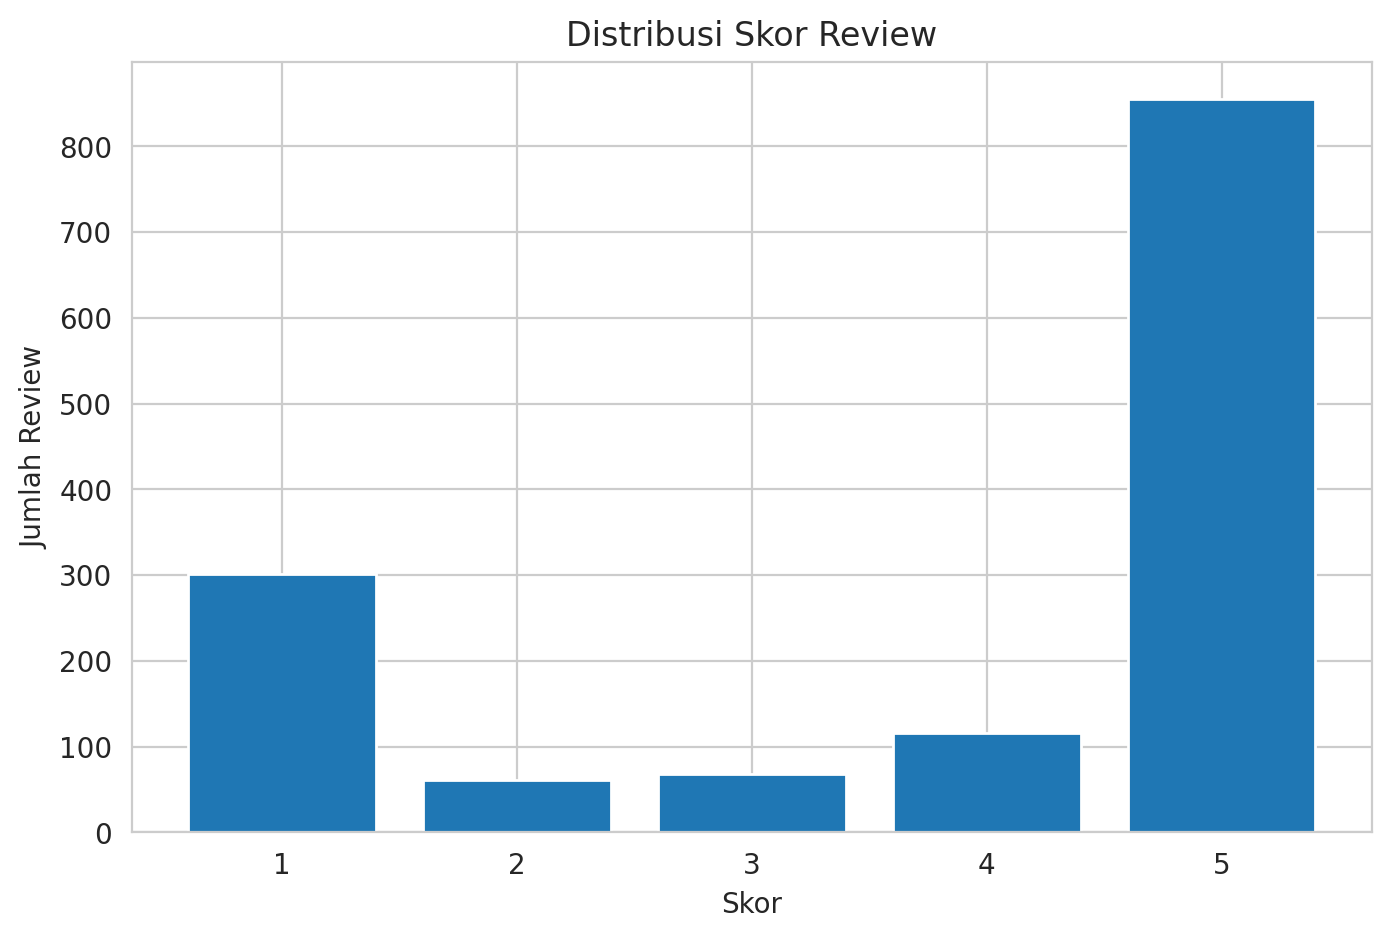

In [4]:
# Kolom yang tidak diperlukan untuk analisis sentimen
df_mymrtjrev_filtered = df_mymrtjrev.loc[:,["content","score","thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt"]]
print("\nInformasi DataFrame awal:")
df_mymrtjrev_filtered.info()

# Cek jumlah skor review
print("\nDistribusi skor review:")
print(df_mymrtjrev['score'].value_counts())
plt.figure(figsize=(8, 5))
plt.hist(df_mymrtjrev['score'], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], rwidth=0.8)
plt.title('Distribusi Skor Review')
plt.xlabel('Skor')
plt.ylabel('Jumlah Review')
plt.xticks([1, 2, 3, 4, 5])
plt.show()

In [5]:
# Preprocessing Pipeline
import nltk

# Download resource untuk tokenisasi
nltk.download('punkt')
nltk.download('punkt_tab')

# Membuat salinan dataframe untuk proses preprocessing
df_processed = df_mymrtjrev.copy()

# 1. Lower casing: Mengubah semua teks menjadi huruf kecil
df_processed['content'] = df_processed['content'].astype(str).apply(lambda x: x.lower())
print("\nLangkah 1/6: Lowercasing selesai.")

# 2. Expand Contractions: Mengembangkan singkatan umum Bahasa Indonesia
# Contoh singkatan informal dan padanannya
contraction_mapping = {
    "yg": "yang", "udah": "sudah", "ga": "tidak", "gak": "tidak",
    "bgt": "banget", "bgtt": "banget", "jg": "juga", "aja": "saja",
    "bkn": "bukan", "tdk": "tidak", "jd": "jadi", "tp": "tapi",
    "gk": "tidak", "blm": "belum", "sdh": "sudah", "krn": "karena",
    "dgn": "dengan", "utk": "untuk", "sampe": "sampai", "udh": "sudah",
    "dr": "dari", "dlm": "dalam", "bbrp": "beberapa", "bs": "bisa",
    "mrt": "mass rapid transit", # contoh: bisa diganti jika ingin mempertahankan 'mrt'
    "app": "aplikasi" # contoh
}

def expand_contractions(text, mapping):
    words = text.split()
    expanded_words = [mapping[word] if word in mapping else word for word in words]
    return ' '.join(expanded_words)

df_processed['content'] = df_processed['content'].apply(lambda x: expand_contractions(x, contraction_mapping))
print("Langkah 2/6: Expand Contractions selesai.")

# 3. Punctuations Removal: Menghapus tanda baca
df_processed['content'] = df_processed['content'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
print("Langkah 3/6: Punctuations Removal selesai.")

# 4. Tokenization: Memecah teks menjadi kata-kata
# Hapus `language='indonesian'`
df_processed['tokens'] = df_processed['content'].apply(word_tokenize)
print("Langkah 4/6: Tokenization selesai.")
print("Contoh token setelah tokenisasi:", df_processed['tokens'].head(2).tolist())

# 5. Stopword Removal: Menghapus kata-kata tidak penting (stopword)
# Stopword Bahasa Indonesia dari Sastrawi dan NLTK
factory_stopword = StopWordRemoverFactory()
sastrawi_stopwords = factory_stopword.get_stop_words()
indonesian_stopwords_nltk = stopwords.words('indonesian')

# Stopword Bahasa Inggris dari NLTK
english_stopwords = stopwords.words('english')

# Custom stopwords (dapat ditambahkan/disesuaikan berdasarkan analisis frekuensi kata)
custom_stopwords = [
    'yg', 'bs', 'tyt', 'aja', 'loh', 'deh', 'dong', 'sih', 'nya', 'nih', 'udah',
    'bgt', 'banget', 'gak', 'ga', 'gk', 'jg', 'mrtj', 'mrt', 'aplikasi', 'review',
    'halo', 'admin', 'kak', 'min', 'hi', 'hai', 'terima', 'kasih', 'bantu'
]

# Gabungkan semua stopword menjadi satu set agar pencarian lebih cepat
all_stopwords = set(sastrawi_stopwords + indonesian_stopwords_nltk + english_stopwords + custom_stopwords)

df_processed['tokens_no_stopwords'] = df_processed['tokens'].apply(
    lambda x: [word for word in x if word not in all_stopwords and len(word) > 1 and not word.isdigit()]
) # Menghapus stopword, token 1 karakter, dan angka
print("Langkah 5/6: Stopword Removal (Indonesia, Inggris, dan kustom) selesai.")
print("Contoh token setelah stopword removal:", df_processed['tokens_no_stopwords'].head(2).tolist())

# 6. Stemming: Mengubah kata menjadi bentuk dasar menggunakan Sastrawi
factory_stemmer = StemmerFactory()
sastrawi_stemmer = factory_stemmer.create_stemmer()

def sastrawi_stem(word_list):
    return [sastrawi_stemmer.stem(word) for word in word_list]

df_processed['tokens_stemmed'] = df_processed['tokens_no_stopwords'].apply(sastrawi_stem)
print("Langkah 6/6: Stemming (menggunakan Sastrawi) selesai.")
print("Contoh token setelah stemming:", df_processed['tokens_stemmed'].head(2).tolist())

# Menggabungkan kembali token menjadi teks bersih final
df_processed['clean_text_final'] = df_processed['tokens_stemmed'].apply(lambda x: ' '.join(x))

# Pilih hanya kolom yang dibutuhkan
df_export = df_processed[['tokens_stemmed', 'clean_text_final']]
# Simpan ke CSV dan Excel
df_export.to_csv("hasil_preprocessing.csv", index=False, encoding="utf-8")
df_export.to_excel("hasil_preprocessing.xlsx", index=False, engine="openpyxl")

print("Data berhasil disimpan ke 'hasil_preprocessing.csv' dan 'hasil_preprocessing.xlsx'")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



Langkah 1/6: Lowercasing selesai.
Langkah 2/6: Expand Contractions selesai.
Langkah 3/6: Punctuations Removal selesai.
Langkah 4/6: Tokenization selesai.
Contoh token setelah tokenisasi: [['opsi', 'pembayaran', 'untuk', 'bank', 'tidak', 'lengkap', 'masih', 'di', 'monopoli', 'blu', 'bca'], ['kalau', 'bikin', 'aplikasi', 'yang', 'niat', 'kalo', 'hujan', 'knp', 'harus', 'error', 'terus', 'tidak', 'bisa', 'dibuka', 'ganti', 'pihak', 'ketiga', 'rombak', 'tim', 'it', 'ini', 'jakarta', 'bukan', 'kota', 'kecil', 'masih', 'banyak', 'tenaga', 'it', 'yang', 'mumpuni', 'memalukan']]
Langkah 5/6: Stopword Removal (Indonesia, Inggris, dan kustom) selesai.
Contoh token setelah stopword removal: [['opsi', 'pembayaran', 'bank', 'lengkap', 'monopoli', 'blu', 'bca'], ['bikin', 'niat', 'kalo', 'hujan', 'knp', 'error', 'dibuka', 'ganti', 'ketiga', 'rombak', 'tim', 'jakarta', 'kota', 'tenaga', 'mumpuni', 'memalukan']]
Langkah 6/6: Stemming (menggunakan Sastrawi) selesai.
Contoh token setelah stemming: [['o

In [6]:
# Rare Words Removal
all_words_clean = ' '.join(df_processed['clean_text_final']).split()
fdist_clean = FreqDist(all_words_clean)

# Ambang batas untuk kata-kata jarang (misal muncul kurang dari 3 kali)
rare_words_threshold = 3
rare_words = set(word for word, count in fdist_clean.items() if count < rare_words_threshold)

def remove_rare_words(text_list, rare_words_set):
    return [word for word in text_list if word not in rare_words_set]

df_processed['tokens_final_filtered'] = df_processed['tokens_stemmed'].apply(
    lambda x: remove_rare_words(x, rare_words)
)
df_processed['clean_text_final'] = df_processed['tokens_final_filtered'].apply(lambda x: ' '.join(x))
print("Langkah opsional: Penghapusan kata-kata jarang selesai.")

Langkah opsional: Penghapusan kata-kata jarang selesai.


In [7]:
# Hitung sentimen sebelum menyimpan data bersih
# Ini menggunakan kolom 'content' asli untuk konsistensi dengan visualisasi awal.
df_processed['sentiment_polarity'] = df_mymrtjrev['content'].astype(str).apply(lambda x: TextBlob(x).polarity)
df_processed['sentiment_subjective'] = df_mymrtjrev['content'].astype(str).apply(lambda x: TextBlob(x).subjectivity)
df_processed['sentiment_rating'] = df_mymrtjrev['score'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3 else 'Negative'))

In [8]:
# Simpan Data Bersih ke CSV dan Excel
df_processed_final = df_processed.loc[:, ["content", "score", "sentiment_polarity", "sentiment_subjective", "sentiment_rating", "clean_text_final"]]
df_processed_final.to_csv('cleandata.csv', index=False)
df_processed_final.to_excel('cleandata.xlsx', index=False)
print("\nData bersih berhasil disimpan ke cleandata.csv dan cleandata.xlsx")

# Tampilkan sampel data yang sudah bersih
print("\nSampel data setelah preprocessing:")
print(df_processed_final.head())


Data bersih berhasil disimpan ke cleandata.csv dan cleandata.xlsx

Sampel data setelah preprocessing:
                                             content  score  \
0  opsi pembayaran untuk bank tidak lengkap masih...      1   
1  kalau bikin aplikasi yang niat kalo hujan knp ...      1   
2  ke balik milih setasiun buat masuk sudah nyamp...      1   
3                        tidak bisa bayar pakai qris      1   
4  sukaa dari segi pembayaran masih dipermudah se...      5   

   sentiment_polarity  sentiment_subjective sentiment_rating  \
0                 0.0              0.000000         Negative   
1                 0.0              0.000000         Negative   
2                 0.0              0.000000         Negative   
3                 0.0              0.000000         Negative   
4                 0.0              0.357143         Positive   

                                    clean_text_final  
0                    opsi bayar bank lengkap blu bca  
1   bikin niat kalo knp

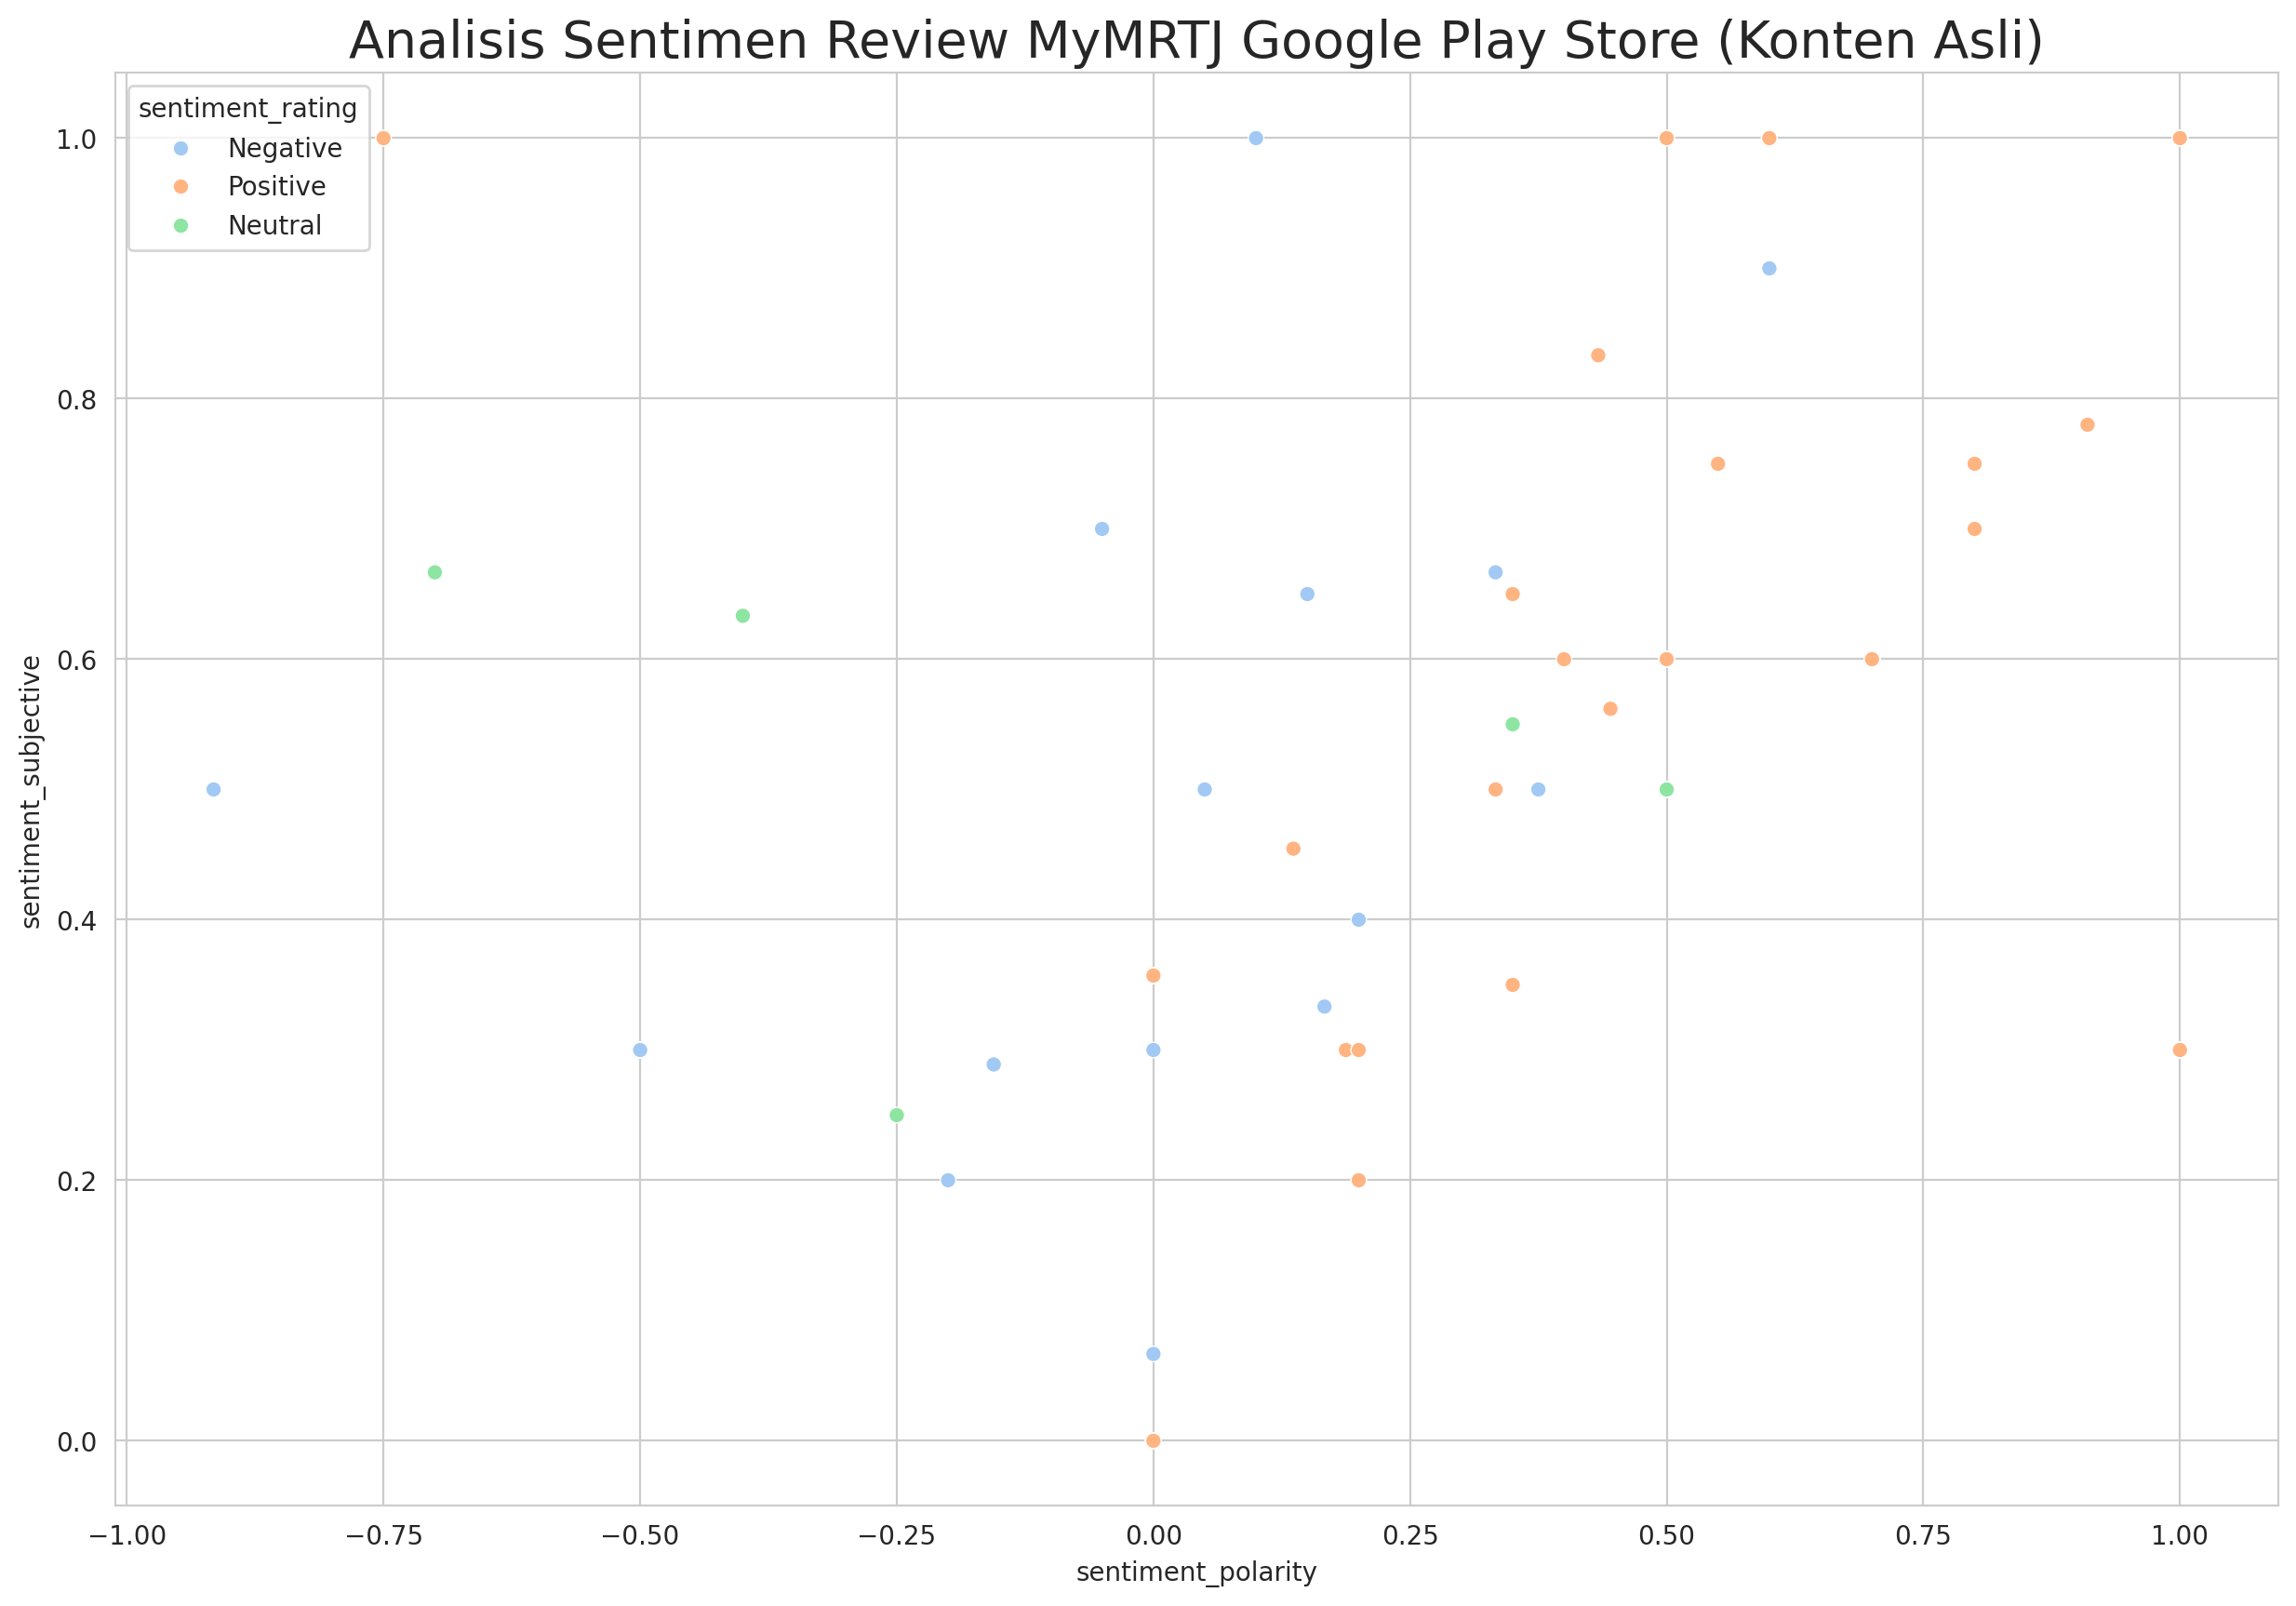

In [9]:
# Analisis Sentimen Awal (pada konten asli)
plt.figure(figsize=(15, 10))
sns.scatterplot(x=df_processed_final['sentiment_polarity'], y=df_processed_final['sentiment_subjective'], hue=df_processed_final['sentiment_rating'], edgecolor='white', palette="pastel")
plt.title("Analisis Sentimen Review MyMRTJ Google Play Store (Konten Asli)", fontsize=20)
plt.show()

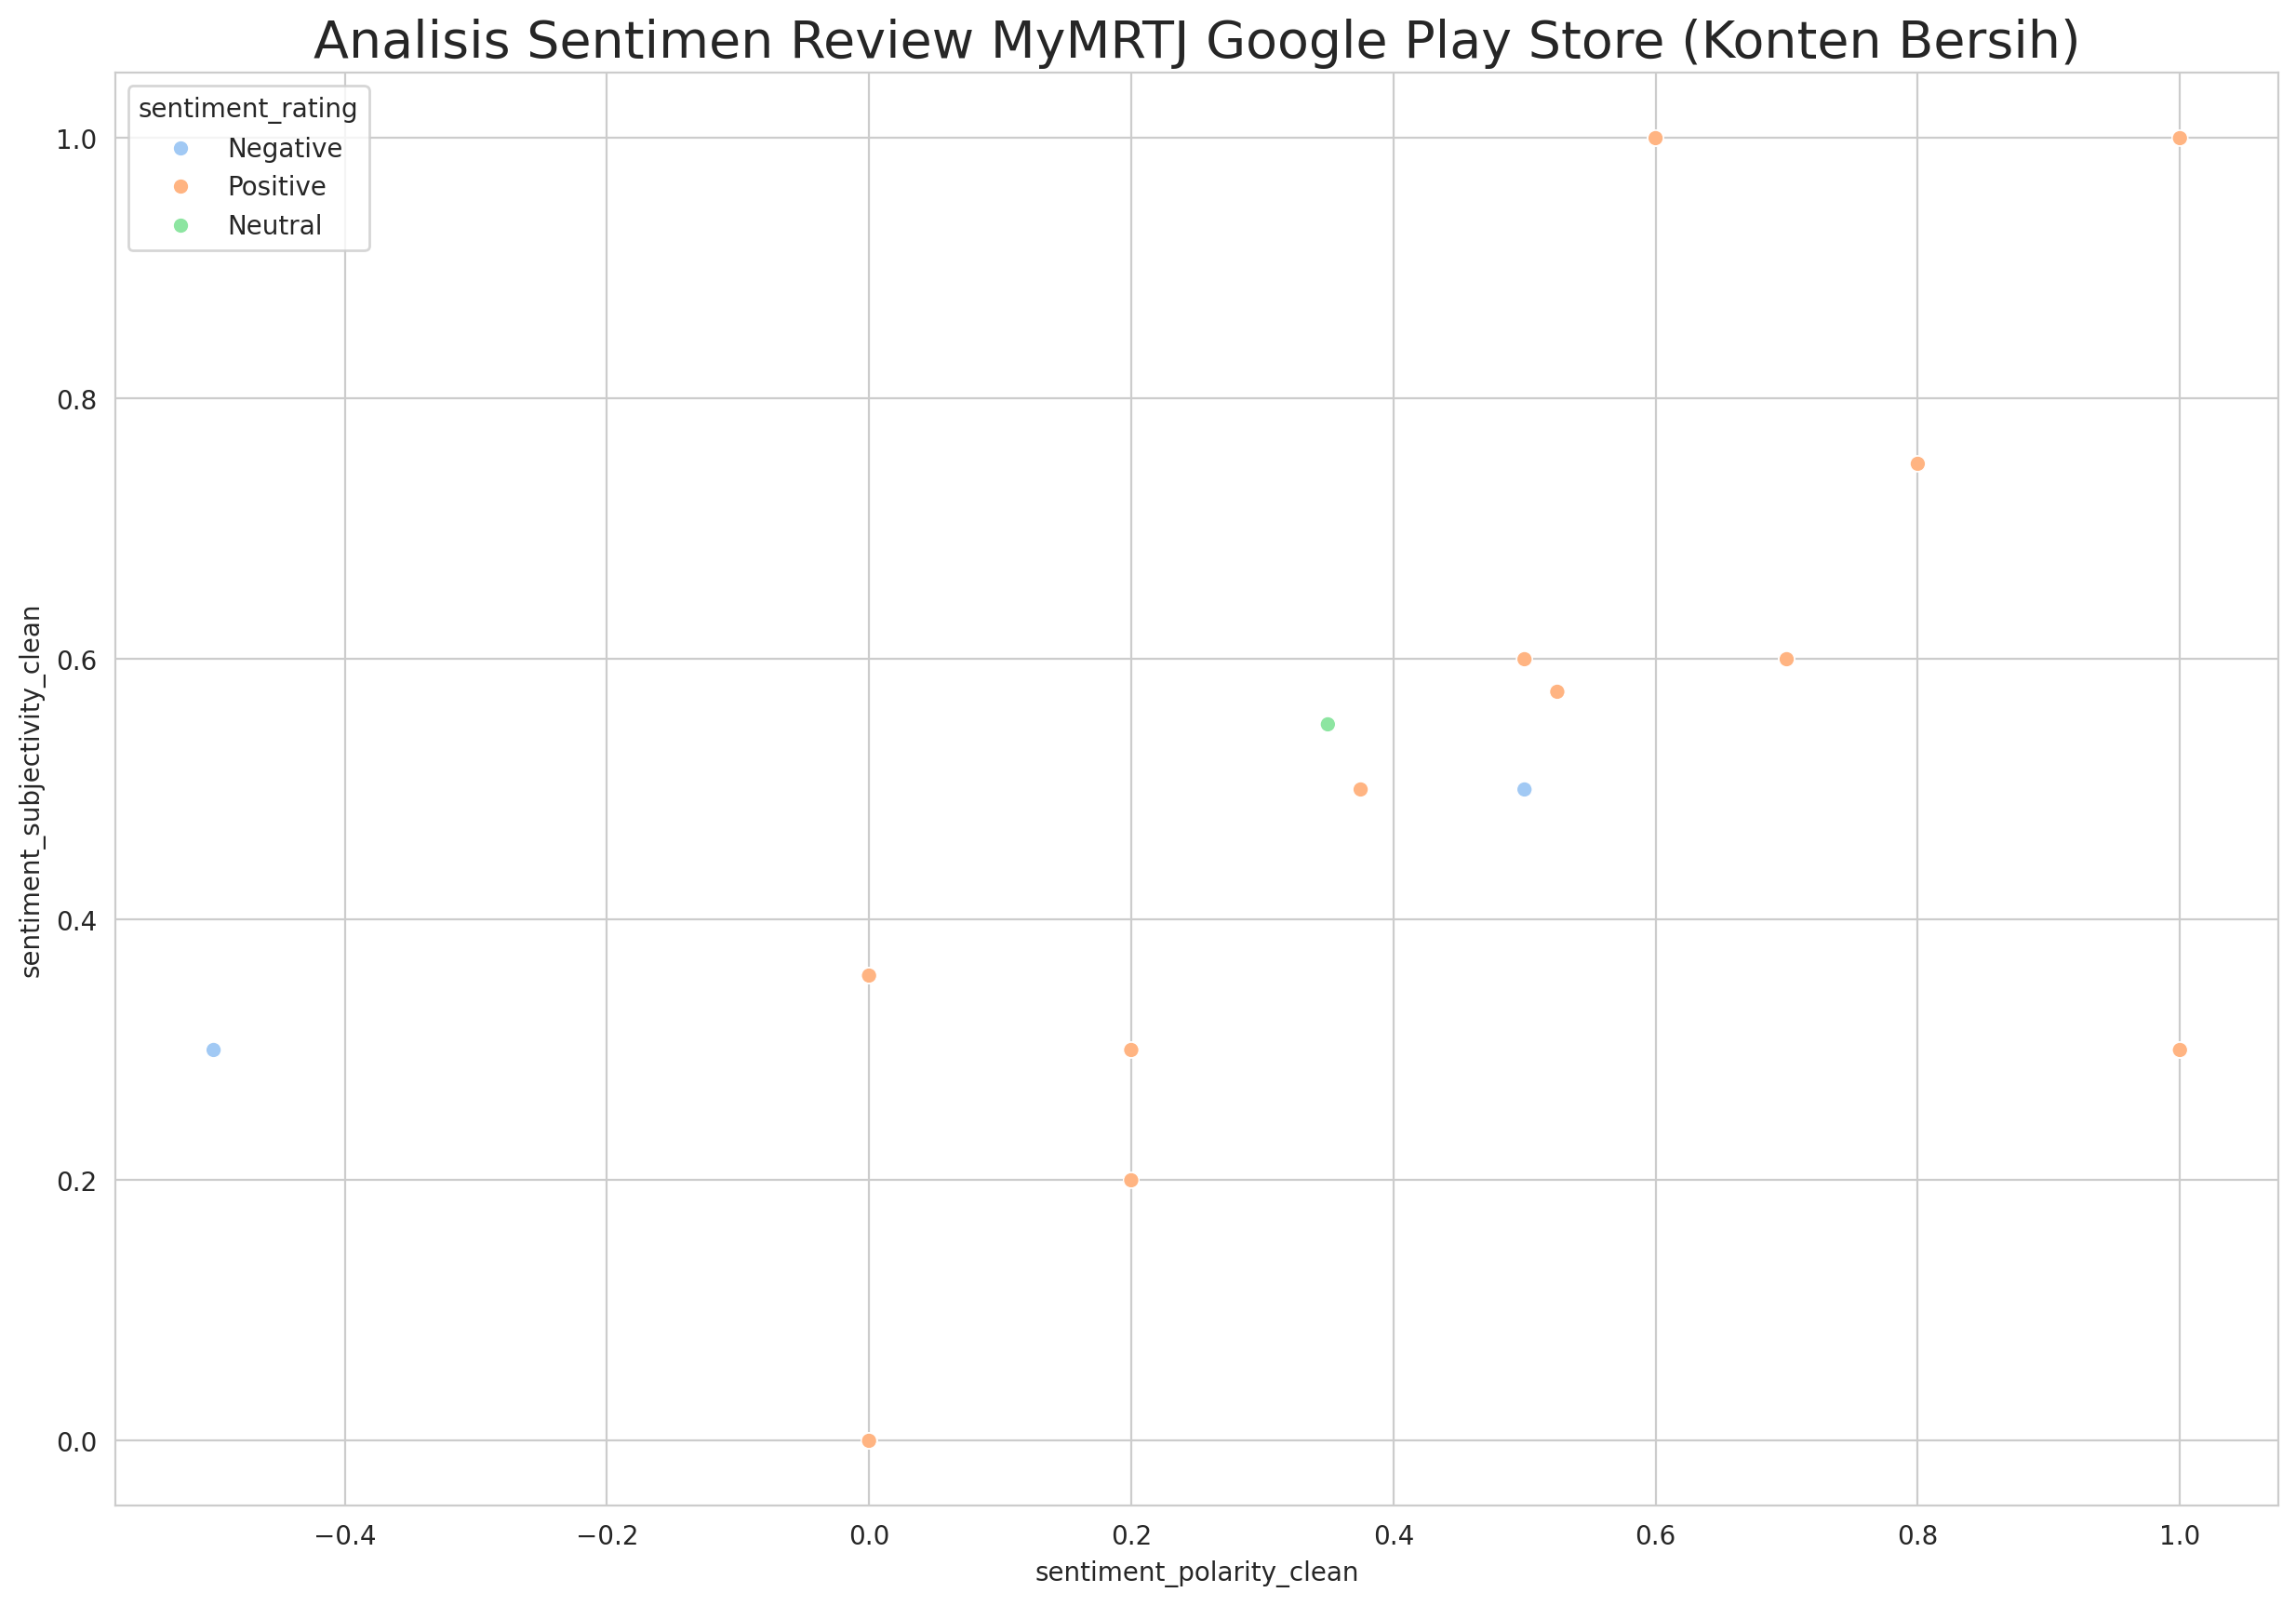

In [10]:
# Analisis Sentimen dengan Teks Bersih (Opsional, dengan catatan)
df_processed_final['sentiment_polarity_clean'] = df_processed_final['clean_text_final'].apply(lambda x: TextBlob(x).polarity)
df_processed_final['sentiment_subjectivity_clean'] = df_processed_final['clean_text_final'].apply(lambda x: TextBlob(x).subjectivity)

plt.figure(figsize=(15, 10))
sns.scatterplot(x=df_processed_final['sentiment_polarity_clean'], y=df_processed_final['sentiment_subjectivity_clean'], hue=df_processed_final['sentiment_rating'], edgecolor='white', palette="pastel")
plt.title("Analisis Sentimen Review MyMRTJ Google Play Store (Konten Bersih)", fontsize=20)
plt.show()


--- Analisis Kata Sering Muncul dari Teks yang Sudah Bersih ---

Kata-kata Paling Sering Muncul (n=50):
             word  count
84          bagus    146
1           bayar    140
150          mass    133
151         rapid    133
152       transit    133
35           good     90
23          mudah     87
110        mantap     87
19          tiket     76
20           pake     71
99           beli     71
79          bantu     64
259         keren     54
21          pakai     49
55           coba     49
65          gopay     49
107        daftar     46
14        jakarta     40
15          masuk     38
43           moga     37
51           guna     36
60         metode     35
95         nyaman     34
177      aplikasi     34
74           kode     33
109  transportasi     32
130         ribet     31
75            otp     30
144           ovo     30
227          akun     30
42        stasiun     28
63          jalan     28
10          error     27
24           dana     26
129         cepat   

/tmp/ipython-input-1019724761.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")


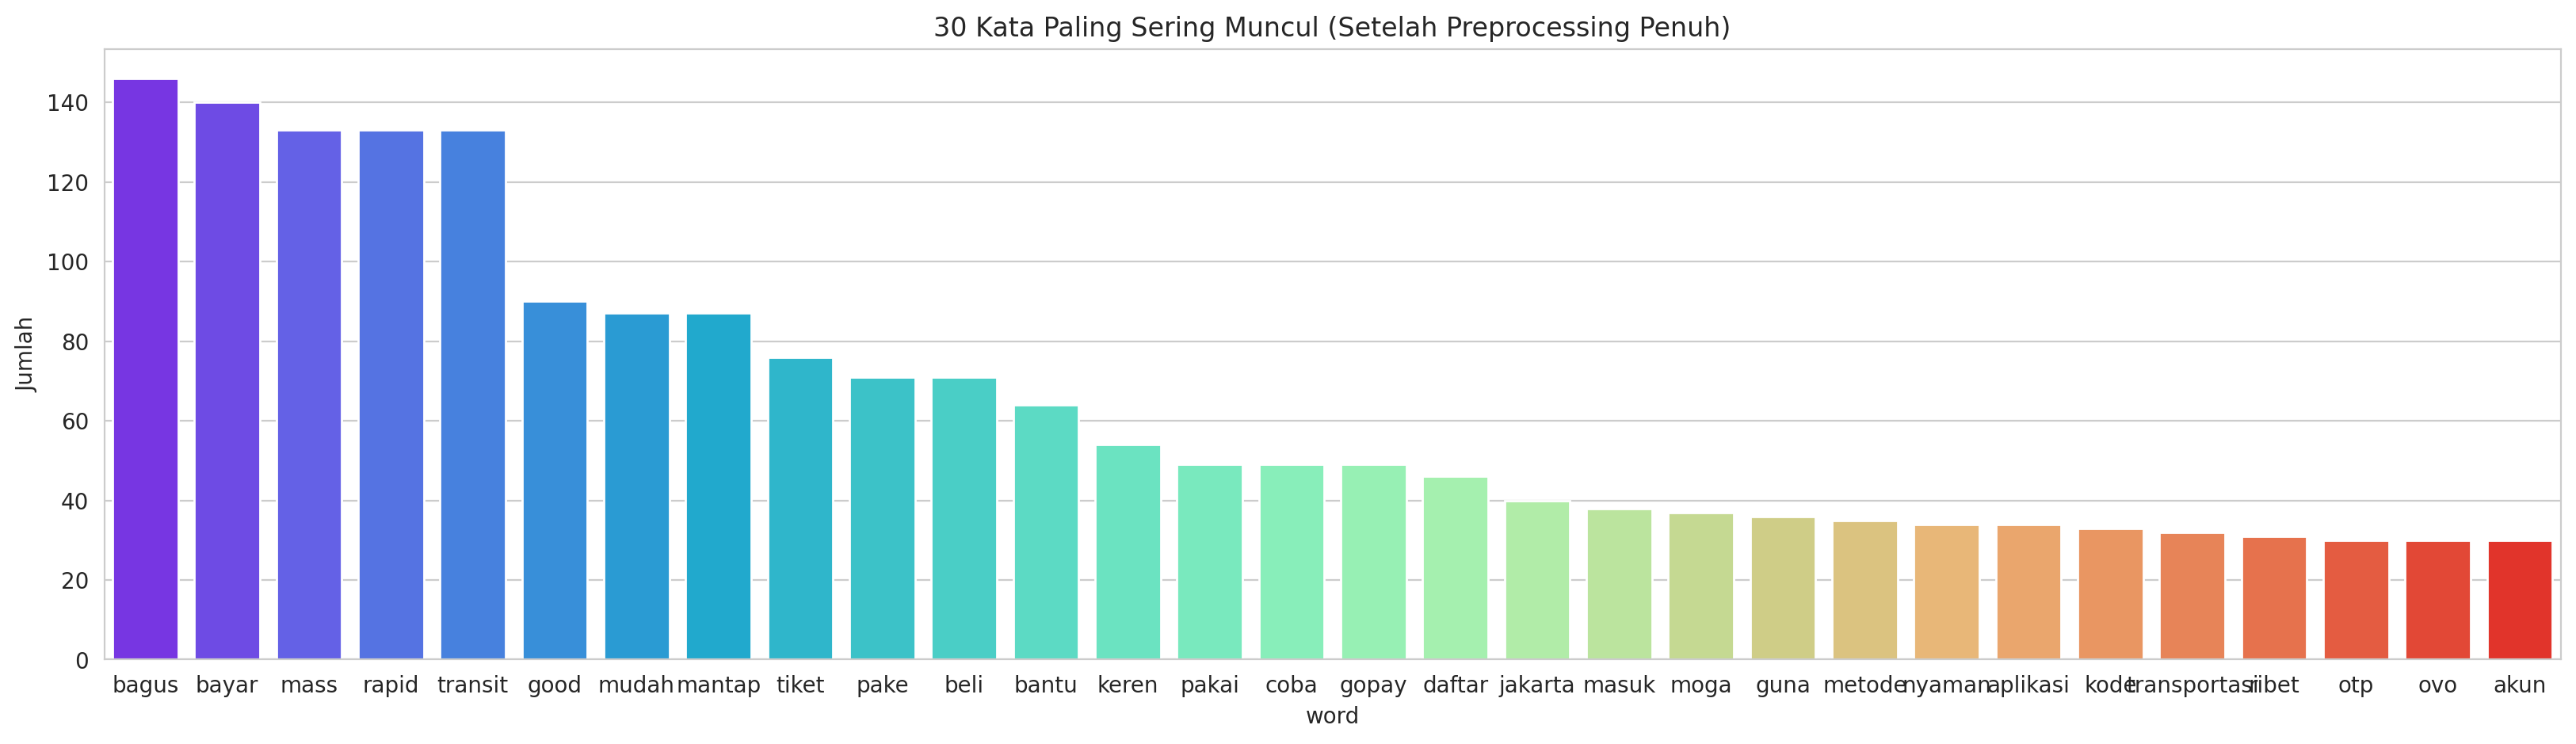


Pipeline preprocessing NLP telah selesai. 'cleandata.csv' dan 'cleandata.xlsx' berisi data yang telah diproses.
Analisis kata-kata yang sering muncul dapat digunakan untuk penyempurnaan stopword kustom di masa mendatang.
Catatan: Untuk analisis sentimen Bahasa Indonesia yang lebih akurat, pertimbangkan penggunaan model sentimen khusus Bahasa Indonesia.


In [11]:
# Analisis Kata Sering Muncul (Frequent Words) dari Teks Bersih
print("\n--- Analisis Kata Sering Muncul dari Teks yang Sudah Bersih ---")
all_words_final_processed = ' '.join(df_processed_final['clean_text_final']).split()
fdist_final_processed = FreqDist(all_words_final_processed)
words_df_final_processed = pd.DataFrame({'word':list(fdist_final_processed.keys()), 'count':list(fdist_final_processed.values())})

# Tampilkan kata-kata paling sering muncul (n=50)
print("\nKata-kata Paling Sering Muncul (n=50):")
print(words_df_final_processed.nlargest(columns="count", n=50))

# Tampilkan kata-kata paling sering muncul (n=100)
print("\nKata-kata Paling Sering Muncul (n=100):")
print(words_df_final_processed.nlargest(columns="count", n=100))

# Tampilkan kata-kata paling sering muncul (n=1000)
print("\nKata-kata Paling Sering Muncul (n=1000):")
print(words_df_final_processed.nlargest(columns="count", n=1000))

# Fungsi untuk memplot kata-kata yang paling sering muncul
def plot_freq_words(df_words, terms = 30, title="Kata-kata Paling Sering Muncul"):
    d = df_words.nlargest(columns="count", n = terms)
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")
    ax.set(ylabel = 'Jumlah', title = title)
    plt.show()

plot_freq_words(words_df_final_processed, terms=30, title="30 Kata Paling Sering Muncul (Setelah Preprocessing Penuh)")

print("\nPipeline preprocessing NLP telah selesai. 'cleandata.csv' dan 'cleandata.xlsx' berisi data yang telah diproses.")
print("Analisis kata-kata yang sering muncul dapat digunakan untuk penyempurnaan stopword kustom di masa mendatang.")
print("Catatan: Untuk analisis sentimen Bahasa Indonesia yang lebih akurat, pertimbangkan penggunaan model sentimen khusus Bahasa Indonesia.")

# Week 3

In [12]:
# --- BAGIAN ANALISIS BAG OF WORDS (BoW) DAN KLASIFIKASI SENTIMEN ---
# Impor modul yang dibutuhkan untuk bagian ini
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Konfigurasi plot untuk bagian ini (jika diperlukan)
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15,10)

In [13]:
# 1. Memuat Data yang Sudah Bersih
# Asumsi 'cleandata.csv' sudah dihasilkan dari proses preprocessing sebelumnya
try:
    df_processed_final = pd.read_csv('cleandata.csv')
    print("\nData bersih berhasil dimuat dari cleandata.csv")
    # Pastikan kolom 'clean_text_final' dan 'sentiment_rating' ada
    if 'clean_text_final' not in df_processed_final.columns or \
       'sentiment_rating' not in df_processed_final.columns:
        raise ValueError("Kolom 'clean_text_final' atau 'sentiment_rating' tidak ditemukan di cleandata.csv.")
except FileNotFoundError:
    print("Error: cleandata.csv tidak ditemukan. Pastikan Anda telah menjalankan bagian preprocessing sebelumnya.")
    exit() # Keluar jika file tidak ditemukan
except ValueError as e:
    print(f"Error: {e}. Pastikan file cleandata.csv memiliki kolom yang benar.")
    exit()

# Tampilkan sampel data bersih yang dimuat
print("\nSampel data bersih yang dimuat:")
print(df_processed_final.head())


Data bersih berhasil dimuat dari cleandata.csv

Sampel data bersih yang dimuat:
                                             content  score  \
0  opsi pembayaran untuk bank tidak lengkap masih...      1   
1  kalau bikin aplikasi yang niat kalo hujan knp ...      1   
2  ke balik milih setasiun buat masuk sudah nyamp...      1   
3                        tidak bisa bayar pakai qris      1   
4  sukaa dari segi pembayaran masih dipermudah se...      5   

   sentiment_polarity  sentiment_subjective sentiment_rating  \
0                 0.0              0.000000         Negative   
1                 0.0              0.000000         Negative   
2                 0.0              0.000000         Negative   
3                 0.0              0.000000         Negative   
4                 0.0              0.357143         Positive   

                                    clean_text_final  
0                    opsi bayar bank lengkap blu bca  
1   bikin niat kalo knp error buka ganti tim 

In [14]:
# 2. Menyiapkan Data untuk Pemodelan
# Fitur (X) adalah teks bersih, Target (y) adalah rating sentimen
X = df_processed_final['clean_text_final']
y = df_processed_final['sentiment_rating']

# Cek distribusi target sentimen
print("\nDistribusi kategori sentimen:")
print(y.value_counts())


Distribusi kategori sentimen:
sentiment_rating
Positive    971
Negative    362
Neutral      68
Name: count, dtype: int64


In [15]:
# 3. Pembagian Data (Training-Test Split)
# Membagi data menjadi 80% pelatihan dan 20% pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nJumlah data training: {len(X_train)}")
print(f"Jumlah data testing: {len(X_test)}")
print("Distribusi sentimen pada data training:")
print(y_train.value_counts(normalize=True))
print("Distribusi sentimen pada data testing:")
print(y_test.value_counts(normalize=True))


Jumlah data training: 1120
Jumlah data testing: 281
Distribusi sentimen pada data training:
sentiment_rating
Positive    0.692857
Negative    0.258929
Neutral     0.048214
Name: proportion, dtype: float64
Distribusi sentimen pada data testing:
sentiment_rating
Positive    0.693950
Negative    0.256228
Neutral     0.049822
Name: proportion, dtype: float64


In [16]:
# 4. Ekstraksi Fitur menggunakan Bag of Words (CountVectorizer)
# Inisialisasi CountVectorizer
# max_features: Membatasi jumlah kata unik yang digunakan as fitur (misal 5000 kata paling sering).
# ngram_range: (1,1) berarti hanya menggunakan unigram (kata tunggal).
#              Jika ingin menyertakan bigram, bisa diubah jadi (1,2).
vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,1))

# Fill NaN values with empty strings
X_train = X_train.fillna('')
X_test = X_test.fillna('')

# Fitur BoW untuk data training
X_train_bow = vectorizer.fit_transform(X_train)
# Transformasi fitur BoW untuk data testing (gunakan vectorizer yang sama yang sudah di-fit pada data training)
X_test_bow = vectorizer.transform(X_test)

print(f"\nDimensi fitur BoW (training): {X_train_bow.shape}")
print(f"Dimensi fitur BoW (testing): {X_test_bow.shape}")
print(f"Jumlah kata unik (vocabulary) yang digunakan: {len(vectorizer.get_feature_names_out())}")

# Menampilkan beberapa fitur (kata) yang digunakan oleh CountVectorizer
print("\nBeberapa contoh fitur (kata) dari CountVectorizer (50 kata pertama):")
print(vectorizer.get_feature_names_out()[:50])


Dimensi fitur BoW (training): (1120, 385)
Dimensi fitur BoW (testing): (281, 385)
Jumlah kata unik (vocabulary) yang digunakan: 385

Beberapa contoh fitur (kata) dari CountVectorizer (50 kata pertama):
['2x' 'abis' 'account' 'ajar' 'akses' 'aktif' 'akun' 'alam' 'alarm'
 'alhamdulillah' 'aman' 'anak' 'android' 'aneh' 'anggap' 'anies' 'antri'
 'apk' 'apknya' 'aplikasi' 'app' 'applikasi' 'appnya' 'apps' 'arah'
 'astra' 'astrapay' 'atur' 'auto' 'bagus' 'baik' 'bangga' 'bank' 'bantu'
 'banyak' 'baru' 'batas' 'bawa' 'bayar' 'bca' 'beda' 'beli' 'bener'
 'berangkat' 'beres' 'bersih' 'best' 'bgus' 'biar' 'biaya']


In [17]:
# 5. Pemodelan Klasifikasi Sentimen (menggunakan Logistic Regression sebagai contoh)
print("\nMelatih model klasifikasi (Logistic Regression)...")
model_bow = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear') # Gunakan solver 'liblinear' untuk dataset kecil/menengah
model_bow.fit(X_train_bow, y_train)
print("Model selesai dilatih.")


Melatih model klasifikasi (Logistic Regression)...
Model selesai dilatih.



Melakukan evaluasi model pada data testing...

--- Laporan Klasifikasi ---
              precision    recall  f1-score   support

    Negative       0.84      0.71      0.77        72
     Neutral       0.00      0.00      0.00        14
    Positive       0.87      0.96      0.91       195

    accuracy                           0.85       281
   macro avg       0.57      0.56      0.56       281
weighted avg       0.82      0.85      0.83       281

Akurasi Model BoW: 0.8505


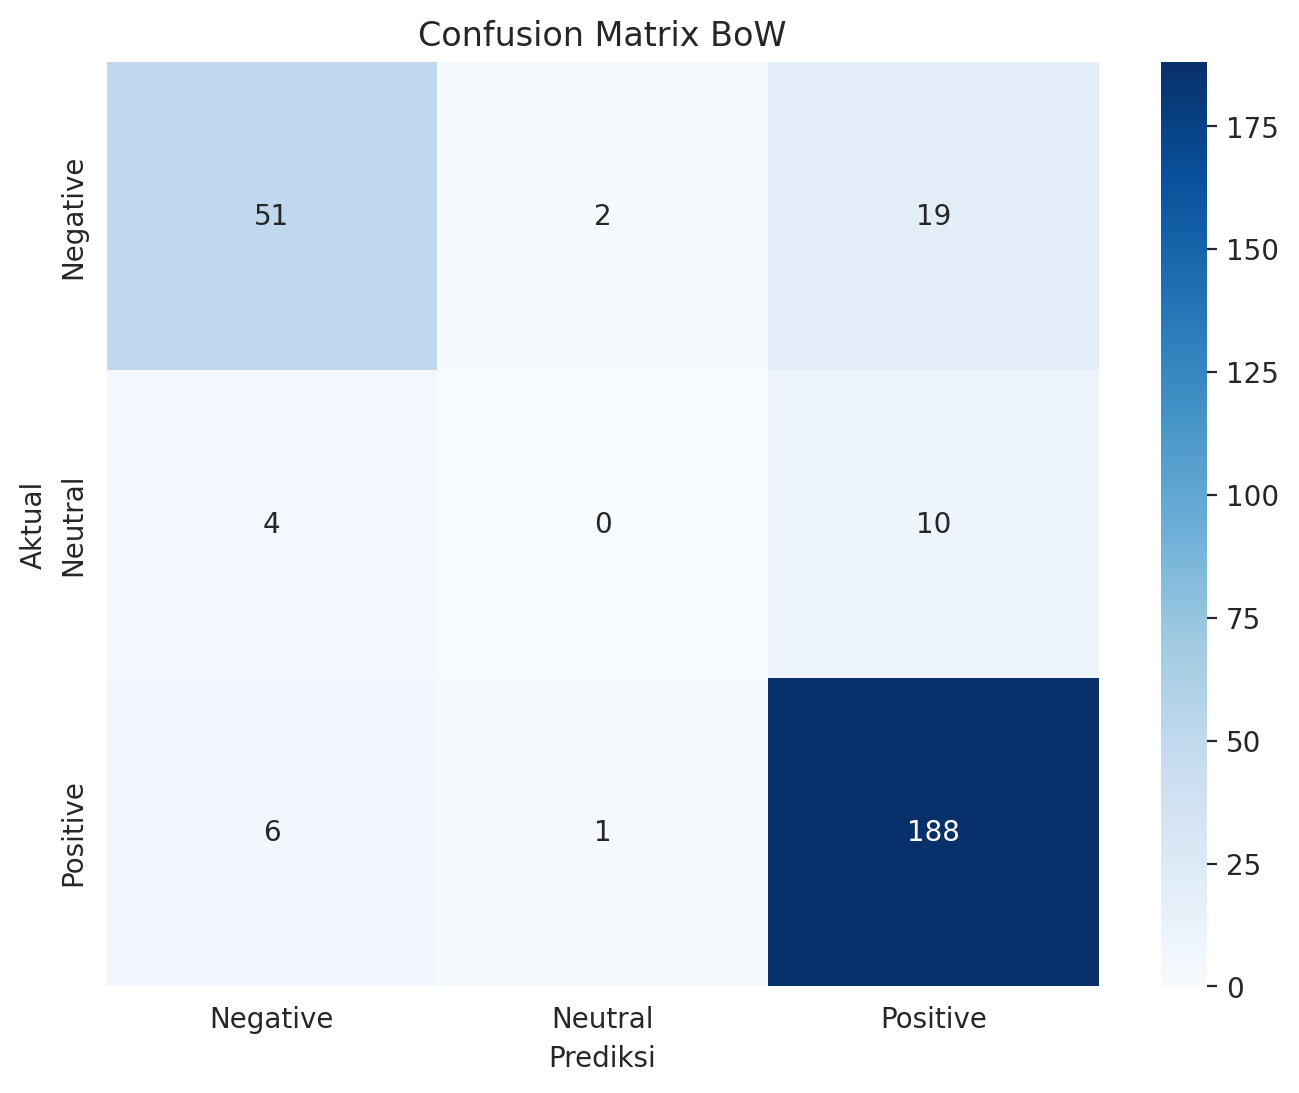

In [18]:
# 6. Evaluasi Model
print("\nMelakukan evaluasi model pada data testing...")
y_pred_bow = model_bow.predict(X_test_bow)

print("\n--- Laporan Klasifikasi ---")
print(classification_report(y_test, y_pred_bow))

accuracy_bow = accuracy_score(y_test, y_pred_bow)
print(f"Akurasi Model BoW: {accuracy_bow:.4f}")

# Visualisasi Confusion Matrix
cm_bow = confusion_matrix(y_test, y_pred_bow)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Blues',
            xticklabels=model_bow.classes_, yticklabels=model_bow.classes_)
plt.title('Confusion Matrix BoW')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

In [19]:
# 7. Menjelajahi Kata-kata Penting untuk Setiap Sentimen (Opsional, tapi informatif)
print("\n--- Kata-kata Penting untuk Setiap Sentimen (dari Model BoW) ---")
feature_names = vectorizer.get_feature_names_out()

# Pastikan urutan kelas sesuai dengan model_bow.classes_
# Jika model_bow.classes_ adalah ['Negative', 'Neutral', 'Positive']
# dan Anda memiliki 3 kelas, maka model_bow.coef_ akan memiliki 3 baris
# yang masing-masing sesuai dengan kelas tersebut.
# Jika hanya 2 kelas, model_bow.coef_ hanya memiliki 1 baris.
if len(model_bow.classes_) == 2: # Binary classification case
    # Menemukan kelas 'Positive' dan 'Negative'
    pos_idx = np.where(model_bow.classes_ == 'Positive')[0][0]
    neg_idx = np.where(model_bow.classes_ == 'Negative')[0][0]

    # Koefisien untuk kelas positif (vs negatif, atau yang lain)
    # Jika cuma 2 kelas, coef_ baris 0 biasanya positif vs negatif
    coef_pos = model_bow.coef_[0] if pos_idx == 0 else -model_bow.coef_[0]
    coef_neg = -coef_pos # kebalikannya

    print(f"\nKata-kata Paling Penting untuk Sentimen 'Positive':")
    sorted_coef_indices = coef_pos.argsort()
    top_n = 10
    top_positive_words = [feature_names[j] for j in sorted_coef_indices[-top_n:]]
    print(f"  Paling berkorelasi positif: {', '.join(top_positive_words[::-1])}")

    print(f"\nKata-kata Paling Penting untuk Sentimen 'Negative':")
    sorted_coef_indices = coef_neg.argsort()
    top_negative_words = [feature_names[j] for j in sorted_coef_indices[-top_n:]]
    print(f"  Paling berkorelasi positif: {', '.join(top_negative_words[::-1])}")

else: # Multiclass classification case (seperti Positive, Neutral, Negative)
    for i, class_label in enumerate(model_bow.classes_):
        print(f"\nKata-kata Paling Penting untuk Sentimen '{class_label}':")
        coefs = model_bow.coef_[i] # Koefisien untuk kelas ini
        sorted_coef_indices = coefs.argsort()

        top_n = 10
        top_positive_words = [feature_names[j] for j in sorted_coef_indices[-top_n:]] # Bobot tertinggi
        top_negative_words = [feature_names[j] for j in sorted_coef_indices[:top_n]] # Bobot terendah (paling berkorelasi negatif)

        print(f"  Paling berkorelasi positif: {', '.join(top_positive_words[::-1])}")
        print(f"  Paling berkorelasi negatif: {', '.join(top_negative_words)}")


print("\n" + "="*70)
print("ANALISIS BAG OF WORDS (BoW) DAN KLASIFIKASI SENTIMEN SELESAI")
print("================================================================")


--- Kata-kata Penting untuk Setiap Sentimen (dari Model BoW) ---

Kata-kata Paling Penting untuk Sentimen 'Negative':
  Paling berkorelasi positif: login, otp, error, bug, buka, hapus, daftar, sulit, akses, update
  Paling berkorelasi negatif: mantap, good, bagus, keren, moga, bantu, proses, oke, mudah, nyaman

Kata-kata Paling Penting untuk Sentimen 'Neutral':
  Paling berkorelasi positif: coba, lumayan, yah, susah, akun, dikit, jadwal, pilih, pesan, astra
  Paling berkorelasi negatif: good, keren, otp, login, pake, tetep, nyaman, orang, aplikasi, kaya

Kata-kata Paling Penting untuk Sentimen 'Positive':
  Paling berkorelasi positif: good, keren, mantap, bagus, mohon, bantu, nyaman, mudah, manfaat, simple
  Paling berkorelasi negatif: error, bayar, pakai, daftar, bug, login, ribet, otp, buka, akses

ANALISIS BAG OF WORDS (BoW) DAN KLASIFIKASI SENTIMEN SELESAI
